please enter start date with format %Y-%m-%d: 2019-1-1
Enter 1st ticker for your portfolio:tsla
Enter 2nd ticker for your portfolio:amzn
Enter 3rd ticker for your portfolio:googl
Enter 4th ticker for your portfolio:fb
the US 10 year treasury bond yield is:
             DGS10
DATE             
2019-09-03   1.47
run 1th time:
 sharpe = [[-1.88012722]] and avg_return = 0.00037442048766981245

run 2th time:
 sharpe = [[-1.9379297]] and avg_return = -0.00019001893676746944

run 3th time:
 sharpe = [[-1.85985161]] and avg_return = 0.0007965083158279271

run 4th time:
 sharpe = [[-1.81859609]] and avg_return = 0.0004425226165088966

run 5th time:
 sharpe = [[-1.88971041]] and avg_return = 0.0005178915581625688

run 6th time:
 sharpe = [[-1.80392769]] and avg_return = 0.00037504791400149086

run 7th time:
 sharpe = [[-1.83479429]] and avg_return = 0.0009204749392756572

run 8th time:
 sharpe = [[-1.72695248]] and avg_return = 0.0009384477195757341

run 9th time:
 sharpe = [[-1.80680754]] and a

run 101th time:
 sharpe = [[-1.76134238]] and avg_return = 0.0009473001910014357

run 102th time:
 sharpe = [[-1.94690478]] and avg_return = -1.219699261112569e-05

run 103th time:
 sharpe = [[-1.80387578]] and avg_return = 0.00016015502142819566

run 104th time:
 sharpe = [[-1.87166798]] and avg_return = -0.0003862635558067657

run 105th time:
 sharpe = [[-1.74906473]] and avg_return = 0.0011671741720243075

run 106th time:
 sharpe = [[-1.66553971]] and avg_return = 0.0015338456622600344

run 107th time:
 sharpe = [[-1.8904593]] and avg_return = 0.0006071638218852674

run 108th time:
 sharpe = [[-1.84698822]] and avg_return = -0.0007749080315990419

run 109th time:
 sharpe = [[-1.86587421]] and avg_return = 0.0006401942440630807

run 110th time:
 sharpe = [[-1.77381422]] and avg_return = 0.0004356593601509474

run 111th time:
 sharpe = [[-1.93978183]] and avg_return = 0.00019166853887137697

run 112th time:
 sharpe = [[-1.92526579]] and avg_return = 0.00031095055898109784

run 113th t

run 221th time:
 sharpe = [[-1.74859291]] and avg_return = 0.0011540665178462288

run 222th time:
 sharpe = [[-1.89673188]] and avg_return = 0.000511075001364472

run 223th time:
 sharpe = [[-1.89983974]] and avg_return = 0.00014030801914200397

run 224th time:
 sharpe = [[-1.84332981]] and avg_return = 0.0005306448475344259

run 225th time:
 sharpe = [[-1.91175012]] and avg_return = 9.487668515804275e-05

run 226th time:
 sharpe = [[-1.86002877]] and avg_return = -0.0004848351217802946

run 227th time:
 sharpe = [[-1.91661659]] and avg_return = 0.00037190051077658226

run 228th time:
 sharpe = [[-1.9483735]] and avg_return = 7.545417749498255e-05

run 229th time:
 sharpe = [[-1.68727853]] and avg_return = 0.001263811801075042

run 230th time:
 sharpe = [[-1.83668775]] and avg_return = 0.0007793471890652182

run 231th time:
 sharpe = [[-1.87609026]] and avg_return = 0.0006682202664199309

run 232th time:
 sharpe = [[-1.66614402]] and avg_return = 0.0014015806271553757

run 233th time:



run 367th time:
 sharpe = [[-1.82737453]] and avg_return = 0.0002414517619400152

run 368th time:
 sharpe = [[-1.86253216]] and avg_return = -0.00031733814878919203

run 369th time:
 sharpe = [[-1.75022898]] and avg_return = 0.00048249436028813855

run 370th time:
 sharpe = [[-1.90896691]] and avg_return = 0.0002679634610157474

run 371th time:
 sharpe = [[-1.69638355]] and avg_return = 0.0012620955161975638

run 372th time:
 sharpe = [[-1.89118445]] and avg_return = -0.00010511533877483113

run 373th time:
 sharpe = [[-1.9182574]] and avg_return = -0.00016892397167532364

run 374th time:
 sharpe = [[-1.92519513]] and avg_return = 0.0002488685370240697

run 375th time:
 sharpe = [[-1.86234521]] and avg_return = 0.0005408802276696615

run 376th time:
 sharpe = [[-1.88000738]] and avg_return = -7.43863390351028e-05

run 377th time:
 sharpe = [[-1.93806225]] and avg_return = -0.00016279130680316905

run 378th time:
 sharpe = [[-1.9323043]] and avg_return = -0.0002896258940211074

run 379

run 504th time:
 sharpe = [[-1.89456381]] and avg_return = -0.0002185989168119339

run 505th time:
 sharpe = [[-1.63446215]] and avg_return = 0.0010946138100120454

run 506th time:
 sharpe = [[-1.87609026]] and avg_return = 0.0006682202664199309

run 507th time:
 sharpe = [[-1.8209795]] and avg_return = 0.0007905212149602742

run 508th time:
 sharpe = [[-1.78075327]] and avg_return = 0.0008490816876741535

run 509th time:
 sharpe = [[-1.7782026]] and avg_return = 0.0008383237587438982

run 510th time:
 sharpe = [[-1.90172599]] and avg_return = 0.0003969486301736543

run 511th time:
 sharpe = [[-1.92715696]] and avg_return = 0.0001448630797843689

run 512th time:
 sharpe = [[-1.72576492]] and avg_return = -0.0009285595298896245

run 513th time:
 sharpe = [[-1.82822731]] and avg_return = 0.00018480556449472686

run 514th time:
 sharpe = [[-1.87467918]] and avg_return = 0.0002767626559951222

run 515th time:
 sharpe = [[-1.91825356]] and avg_return = 2.3903632171227236e-05

run 516th time

run 638th time:
 sharpe = [[-1.91796033]] and avg_return = 5.783105076182643e-05

run 639th time:
 sharpe = [[-1.70210301]] and avg_return = 0.000727828797907922

run 640th time:
 sharpe = [[-1.7444812]] and avg_return = 0.0011335874051282696

run 641th time:
 sharpe = [[-1.87421112]] and avg_return = -0.00026394085977241244

run 642th time:
 sharpe = [[-1.84311919]] and avg_return = 0.0005633917831245137

run 643th time:
 sharpe = [[-1.82913579]] and avg_return = 0.0007553202992436346

run 644th time:
 sharpe = [[-1.78962787]] and avg_return = 0.0009409993769679433

run 645th time:
 sharpe = [[-1.72028121]] and avg_return = 0.0005040766396566024

run 646th time:
 sharpe = [[-1.92387621]] and avg_return = -0.00020587173144507383

run 647th time:
 sharpe = [[-1.68825478]] and avg_return = 0.0014184856986247112

run 648th time:
 sharpe = [[-1.85359309]] and avg_return = 0.0005917690737681927

run 649th time:
 sharpe = [[-1.85494267]] and avg_return = -0.0005492704943970819

run 650th tim

run 770th time:
 sharpe = [[-1.90490791]] and avg_return = 0.0002799922878069599

run 771th time:
 sharpe = [[-1.89413693]] and avg_return = 0.00022435311625879667

run 772th time:
 sharpe = [[-1.91589792]] and avg_return = 0.00025317328279855116

run 773th time:
 sharpe = [[-1.94258349]] and avg_return = -0.0001890772951860965

run 774th time:
 sharpe = [[-1.92403931]] and avg_return = 0.0004204928793818517

run 775th time:
 sharpe = [[-1.78043645]] and avg_return = 0.000598448233055836

run 776th time:
 sharpe = [[-1.88150484]] and avg_return = 0.0005220461677879714

run 777th time:
 sharpe = [[-1.92296216]] and avg_return = -2.9653839087750923e-05

run 778th time:
 sharpe = [[-1.9254154]] and avg_return = 1.5966667219630094e-05

run 779th time:
 sharpe = [[-1.91062943]] and avg_return = 0.00038371579239448994

run 780th time:
 sharpe = [[-1.86943771]] and avg_return = -0.0002754562843652681

run 781th time:
 sharpe = [[-1.84240215]] and avg_return = 0.0008635919404486903

run 782th 

run 900th time:
 sharpe = [[-1.93869465]] and avg_return = -0.00016416085958438257

run 901th time:
 sharpe = [[-1.68234813]] and avg_return = 0.0013503111368855251

run 902th time:
 sharpe = [[-1.86242939]] and avg_return = -0.0006785172705813263

run 903th time:
 sharpe = [[-1.6385037]] and avg_return = 0.0009595426846678795

run 904th time:
 sharpe = [[-1.68256512]] and avg_return = 0.0007547850143254469

run 905th time:
 sharpe = [[-1.93986004]] and avg_return = 0.0002884710512699246

run 906th time:
 sharpe = [[-1.86300396]] and avg_return = 0.0003322440604359283

run 907th time:
 sharpe = [[-1.90771279]] and avg_return = 0.0003826003558275287

run 908th time:
 sharpe = [[-1.91165412]] and avg_return = 0.00045267743521131595

run 909th time:
 sharpe = [[-1.64975084]] and avg_return = 0.0014553974587354296

run 910th time:
 sharpe = [[-1.77677321]] and avg_return = 0.0009849282789244009

run 911th time:
 sharpe = [[-1.94132317]] and avg_return = 0.0002002449590388019

run 912th tim

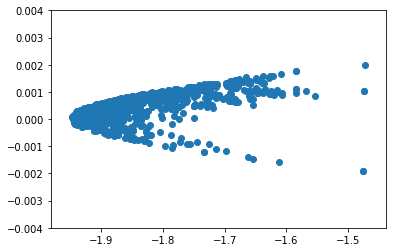

In [23]:
from datetime import timedelta
import matplotlib.pyplot as plt
# import quandl 
import datetime as dt 
import pandas_datareader as pdr 
import pandas as pd 
import numpy as np 
# quandl.ApiConfig.api_key = ''


class portfolio():
    
    def __init__(self, stocks, tickers, start, end ):
        self.num_stock = stocks 
        self.tickers = tickers
        self.start = start 
        self.end = end 
        self.df_close, self.new_tickers = self.get_stock_price()
        self.df_excess, self.df_return = self.excess_return()
        self.covariance_mat = self.variance_covariance_matrix()
        
    def get_stock_price(self):
        df_close = pd.DataFrame([])
        new_tickers = [] 
        for ticker in self.tickers: 
            try:
                df = pdr.DataReader(ticker,'yahoo', start = self.start , end = self.end)
                df_close[ticker] = df['Adj Close']
                new_tickers.append(ticker)  
            except KeyError:
                pass 
        df_close.dropna(inplace = True)
        stock_num = len(df_close.columns)
        return df_close, new_tickers

    def excess_return(self):
        df_excess = pd.DataFrame([])
        df_return = pd.DataFrame([])
        for ticker in self.new_tickers:
            df_return[ticker] = np.log(self.df_close[ticker]).diff()
            df_excess[ticker] = [(i - df_return[ticker].mean(axis = 0)) for i in df_return[ticker].values] #(df.shape[0],ticker)
        df_return.dropna(inplace = True)
        df_excess.dropna(inplace = True)
        return df_excess, df_return  

    def variance_covariance_matrix(self):   
        n = self.df_close.shape[0]
        covariance_matrix = (np.dot((np.array(self.df_excess)/n).T, np.array(self.df_excess))) #(df.shape[0],ticker).T(df.shape[0],ticker) = (ticker,ticker)
        return covariance_matrix #(4,4)

    def std_each_stock(self):
        std = []
        for ticker in self.tickers: 
            a = np.std(np.array(self.df_return[ticker])) #, dtype = np.float64
            std.append(a)
        std_array = np.array(std).reshape(len(self.tickers),1)
        #print("std_array:\n",std_array)
        return std_array 

    def std_matrix(self): 
        std_array = self.std_each_stock() 
        std_mat = np.dot(std_array, std_array.T) #(4,1)(4,1).T = (4,4)
        return std_mat #(stocks, stocks)

    def correlation_matrix(self, weights):
        std_mat = self.std_matrix()
        correlation_mat = self.covariance_mat/std_mat #(4,4)/(4,4)
        
        #print("correlation_mat:\n",correlation_mat)
        return correlation_mat #(4,4)

    def portfolio_risk(self,weights): #Portfolio Variance = Sqrt (Transpose (Wt.SD) * Correlation Matrix * Wt. SD)
        correlation_mat = self.correlation_matrix(weights)
        port_variance = np.dot(np.dot(weights.T, correlation_mat), weights) #{[(4,1).T(4,4) = (1,4)], (4,1)} = (1,1)
        port_std = np.sqrt(port_variance)
        return port_std #(1,1)                   

    def portfolio_return(self,weights):
        average_return_stock ={}
        list_avg_return = []
        avg_return = np.array([])
        for i in self.df_return.columns:
            average_return_stock[i] = self.df_return[i].mean() 
            list_avg_return.append(average_return_stock[i])
        avg_return= np.array(list_avg_return).reshape(1,len(self.df_return.columns))
        expected_return = np.sum(avg_return*weights.T) # (1, ticker)(ticker, 1).T = (df.shape, ticker)
        return expected_return 
    
    def find_current_rf_rate(self):
        end = dt.date.today()
        df = pdr.DataReader('DGS10','fred', start =end, end = end )
        for i in range(30):
            if df.empty:
                end = end + timedelta(-1) 
                df = pdr.DataReader('DGS10','fred', start = end, end = end )
            else:
                print("the US 10 year treasury bond yield is:\n", df.head())
                break 
        return df.values
    
    def Max_sharpe_ratio(self, len_train): # (average return - rf ) /std 
        rf = self.find_current_rf_rate()
        column = ['sharpe', 'return'] + ['weight_{}'.format(i) for i in self.tickers]
        df_risk_return = pd.DataFrame(columns = column, index = [i for i in range(len_train)]) 
        j = 1
        for i in range(0,len_train): 
            k = self.weights_simulation() #(4,1)    
            avg_return = self.portfolio_return(k) #(1,1)
            sharpe = (avg_return - rf)/self.portfolio_risk(k)#[(1,1) - (1,1)]/(1,1)
            df_risk_return.iloc[i,0] = sharpe
            df_risk_return.iloc[i,1] = avg_return
            df_risk_return.iloc[i,2:] = list(k) 
            print("run {}th time:\n sharpe = {} and avg_return = {}\n".format(j,sharpe,avg_return)) 
            j+=1
        print(df_risk_return)
        print("the max sharpe: {}\nand the max return: {}\n".format(df_risk_return['sharpe'].max(),df_risk_return['sharpe'].max()))
        g= np.array(df_risk_return)
        print("len(list(g)):",len(list(g)))
        k = np.argmax(g)
        print("k: ", k)
        print("the corresponding weight of highest sharpe: ", df_risk_return.iloc[k, 2:])
        
        axes = plt.gca()
        axes.set_ylim([-0.004,0.004])
        plt.scatter(list(df_risk_return['sharpe'].values), list(df_risk_return['return'].values))
        return 
    
    def weights_simulation(self):
        b =np.random.randint(10, size = self.num_stock)
        init_weights = np.array([j/np.sum(b) for j in b]).reshape(self.num_stock,1)  #(4,1)  
        return init_weights

    
    
if __name__ == "__main__":
    start = input("please enter start date with format %Y-%m-%d: ")
    end = dt.date.today()
    tickers = []
    stocks = 4 

    for i in range(stocks):  
        num_form = ['st', 'nd','rd','th']
        if i == 0:    
            ticker = input("Enter {}{} ticker for your portfolio:".format(i+1,num_form[i]))
            tickers.append(ticker)
        if i == 1: 
            ticker = input("Enter {}{} ticker for your portfolio:".format(i+1,num_form[i]))
            tickers.append(ticker)
        elif i == 2:
            ticker = input("Enter {}{} ticker for your portfolio:".format(i+1,num_form[i]))
            tickers.append(ticker)
        elif i > 2:
            ticker = input("Enter {}{} ticker for your portfolio:".format(i+1,num_form[i]))
            tickers.append(ticker)

    k = portfolio( stocks = stocks, tickers = tickers, start = start, end = end)
    k.Max_sharpe_ratio(1000)


In [7]:
import pandas as pd 
import numpy as np 
import pandas_datareader as pdr 
j = np.array([])
df = pd.read_csv("/Users/kelly/Desktop/kaggle_data/tsla2018.csv")
j = df['Volume'].max()
k= np.argmax(df['Volume'])
print(k)
print(j)
print(df.iloc[k])


187
33649700
Date         2018-09-28
High                278
Low              260.56
Open             270.26
Close            264.77
Volume         33649700
Adj Close        264.77
Name: 187, dtype: object


/Users/kelly/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
